<a href="https://colab.research.google.com/github/dborgesm/Banking-Analytics/blob/master/Data_Preprocessing_for_Credit_Scoring_Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing



In [0]:
#Installing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
!gdown https://drive.google.com/uc?id=1WPvaqsGs7dE6B9Ahrs_56nG8ZwGbi4FF

Downloading...
From: https://drive.google.com/uc?id=1WPvaqsGs7dE6B9Ahrs_56nG8ZwGbi4FF
To: /content/LCFinal.csv
1.64GB [00:11, 142MB/s] 


In [0]:
lending_data = pd.read_csv('/content/LCFinal.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,17,47,56,115,126,127,128,131,132,133,136,142,143,144) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## **Missing Values**

In [0]:
df_null = pd.DataFrame({'Count': lending_data.isnull().sum(), 'Percent': 100*lending_data.isnull().sum()/len(lending_data)})

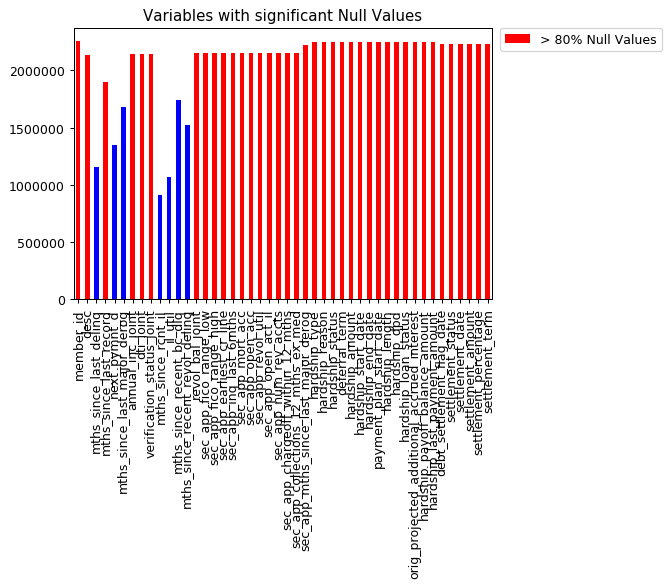

In [0]:
na_col = lending_data.isnull().sum()
na_col = na_col[na_col >0.4*len(lending_data)]
na_col
col_val = []
tr = len(lending_data)
j=0
for i in na_col:
  if i/tr > 0.8:
    col_val.append("r")
    j +=1
  else:
    col_val.append("b")
plt.figure(dpi=90)
na_col.plot(kind='bar', color = tuple(col_val))
plt.show
plt.title("Variables with significant Null Values")
plt.legend(["> 80% Null Values"], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)



Dropping the columns with more than 80% of missing values and the unnecesary columns Unnamed: 0, id and url.

In [0]:
length = len(lending_data)
lending_data2 = lending_data.copy()
lending_data2.drop(lending_data.loc[:,lending_data.isnull().sum()/length >.8], inplace=True, axis=1)

Dropping the rows with many missing values (more than 100 missing values)

In [0]:
na_rows = lending_data2[lending_data2.isnull().sum(axis=1)>100].index
lending_data2.drop(na_rows, inplace=True)

Dropping accounts where the issue_d is from Aug to December 2018 because they do not meet the 1 year requirement to be part in the application scoring model, however if they are defaulted the will be kept because they have already shown their behaviour

In [0]:
issued_less_than_15mths = lending_data2[((lending_data2.issue_d == "Dec-2018") | (lending_data2.issue_d == "Nov-2018") |(lending_data2.issue_d == "Aug-2018") |(lending_data2.issue_d == "Sep-2018") |(lending_data2.issue_d == "Oct-2018")) & (lending_data2.loan_status != "Charged Off")].index
lending_data2.drop(issued_less_than_15mths, inplace=True)

The information required in the application scoring is the one at the moment of the loan is acquired, so next payment date, issue date, last credit pull d and last payment d are not necessary in the model because they are future information. 

In [0]:
lending_data2 = lending_data2.drop(['Unnamed: 0', 'id', 'url', 'issue_d', 'next_pymnt_d', 'last_credit_pull_d', 'last_pymnt_d', "earliest_cr_line"], axis=1)

Dropping rows where loan_status is equal to "Does not meet the credit policy", the company will never give these people a loan.

In [0]:
no_meeting_policy = lending_data2[lending_data2.loan_status.str.contains('Status:')].index
lending_data2.drop(no_meeting_policy, inplace=True)

Modifying some values of the database

In [0]:
#Extracting the first 3 values of the zip code. 

lending_data2['zip_code'] = lending_data2['zip_code'].str.extract(r'([\d\.]+)')


Employment title had more than 200 categories and contained invalid values, and even if new categories were made, they couldn’t reach statistical significance

In [0]:
lending_data2.drop(['emp_title'], inplace=True, axis=1)

In [0]:
# extracting the numeric values of term
lending_data2['term'] = lending_data2['term'].str.extract(r'([\d\.]+)')

## **Creating objective variable for Application Scoring**

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

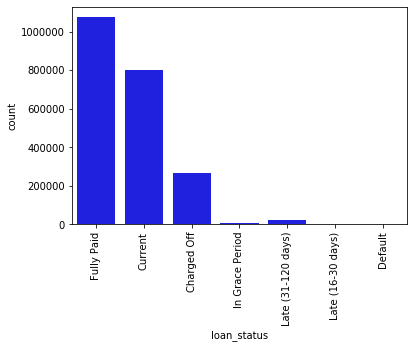

In [0]:
g = sns.countplot(x="loan_status", data=lending_data2, 
                  color='blue')
plt.xticks(rotation=90)

In [0]:
lending_data2['default'] = np.nan
bad_loan = ["Charged Off", "Default"]

def loan_status(status):
  if status in bad_loan:
    return  1
  else:
    return 0
  
lending_data2['default'] = lending_data2['loan_status'].apply(loan_status)

## **Correlation**

In [0]:
corr_as = lending_data2.corr()

Text(0.5, 1, 'Application Scoring Correlation Heat Map')

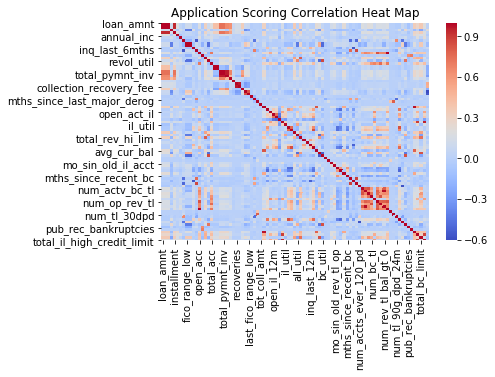

In [0]:
#plt.figure(figsize=(22,15))
sns.heatmap(corr_as, cmap= 'coolwarm',linecolor='black')
plt.title("Application Scoring Correlation Heat Map")

In [0]:
as_data = lending_data2.copy()

I will be dropping some variables that are not related to the pd model, because they contain future information. 

In [0]:
amount_col = ["out_prncp", "total_rec_prncp", "total_rec_int",
          "total_rec_late_fee", "recoveries", "last_pymnt_amnt"
]

In [0]:
as_data.drop(amount_col, axis=1, inplace=True)

Dropping correlated variables

In [0]:
corr_col = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv','installment', "fico_range_low",
'fico_range_high','mths_since_last_delinq','open_acc',
'revol_bal','revol_util','total_acc',
'out_prncp_inv','total_pymnt',	'total_pymnt_inv',
'collection_recovery_fee','last_fico_range_low'
,'tot_cur_bal', 'last_fico_range_high',
'open_acc_6m','open_il_24m','total_bal_il',
'open_rv_12m','open_rv_24m','total_rev_hi_lim',
'avg_cur_bal','bc_util','mths_since_recent_bc_dlq',
'mths_since_recent_revol_delinq','num_actv_bc_tl','num_bc_sats',
'num_bc_tl','num_op_rev_tl','num_rev_tl_bal_gt_0',
'num_sats','num_tl_30dpd','num_tl_op_past_12m',
'tax_liens','total_bal_ex_mort','total_bc_limit',
]

In [0]:
as_data.drop(corr_col, axis=1, inplace=True)

Zip Code and Address State will remain in the db

In [0]:
w = as_data[['zip_code', 'addr_state']]

In [0]:
w = w.apply(lambda x: pd.factorize(x)[0]) + 1

In [0]:
w['default'] = as_data.loan_status2

In [0]:
w.corr(method="spearman")

,zip_code,addr_state,default
zip_code,1.000000,0.154716,0.003487
addr_state,0.154716,1.000000,0.000713
default,0.003487,0.000713,1.000000


Title will be removed from the dataframe because the column purpose group them in a more efficient way


In [0]:
as_data.drop(['title'], inplace=True, axis=1)

### **Categorical Variables**

The categorical variables that contained only one unique value were eliminated, because they would not add any information to the model as they were. Even though, hardship flag is an essential variable for the LGD model this was removed.

In [0]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 4000)
pd.set_option('display.width', 4000)
null_counts = as_data.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

In [0]:
loans = as_data.loc[:,as_data.apply(pd.Series.nunique) != 1]

In [0]:
drop_c = []
for col in loans.columns:
    if (len(loans[col].unique()) < 4):
      print(loans[col].value_counts())
      print()
      drop_c.append(col)


36    1460450
60     584562
Name: term, dtype: int64

n    2044393
y        619
Name: pymnt_plan, dtype: int64

w    1347634
f     697378
Name: initial_list_status, dtype: int64

Individual    1952979
Joint App       92033
Name: application_type, dtype: int64

N    2044181
Y        831
Name: hardship_flag, dtype: int64

Cash         2009290
DirectPay      35722
Name: disbursement_method, dtype: int64

N    2010785
Y      34227
Name: debt_settlement_flag, dtype: int64

0    1776413
1     268599
Name: default, dtype: int64



In [0]:
drop_col = ["pymnt_plan", "application_type", "hardship_flag", "disbursement_method", "debt_settlement_flag"]

pymnt_plan, application_type, hardship_flag, disbursement_method, debt_settlement_flag will be drop from the data because all of the have two categories and the one with less value has less than 5% of the total cases hence they wont be significant

In [0]:
as_data.drop(drop_col, axis=1, inplace=True)

## **Handling Missing Values**

In [0]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 4000)
pd.set_option('display.width', 4000)
null_counts = as_data.isnull().mean()
print("Number of null values in each column:\n{}".format(100*(null_counts)))

Number of null values in each column:
term                            0.000000
int_rate                        0.000000
emp_length                      6.261332
home_ownership                  0.000000
annual_inc                      0.000000
loan_status                     0.000000
purpose                         0.000000
zip_code                        0.000049
addr_state                      0.000000
dti                             0.062640
delinq_2yrs                     0.000000
inq_last_6mths                  0.000049
pub_rec                         0.000000
initial_list_status             0.000000
collections_12_mths_ex_med      0.002738
mths_since_last_major_derog    73.973942
acc_now_delinq                  0.000000
tot_coll_amt                    3.302034
open_act_il                    42.218823
open_il_12m                    42.218823
mths_since_rcnt_il             43.991429
il_util                        50.479997
max_bal_bc                     42.218823
all_util           

The numeric variables with less than 4% of missing values will be filled with the median of that variable

In [0]:
num_var = as_data.drop(['loan_status', 'default'], axis=1).select_dtypes(include = [np.number])
null_nv = num_var.isnull().mean()*100

In [0]:
for i in num_var:
  if (null_nv[i] < 6) & (null_nv[i]> 0.000045):
    as_data[i].fillna(as_data[i].median(), inplace=True)
    

The other numeric variables with significant missing values after analyzing them they will be filled with 0 because it made references to products that the client does not have.

In [0]:
for i in num_var:
  if (null_nv[i] > 6):
    as_data[i].fillna(0, inplace=True)

The only missing value in zip code is where the state is AL, so it will be replaced with the mode when the addr_state is AL.

In [0]:
zip_al = as_data[as_data.addr_state == "AL"].zip_code.mode().values[0]

In [0]:
as_data.zip_code.fillna(zip_al, inplace=True)

I will replace employment date with the mode eventhough there are 6% of null cases value but it will be worst if we dropped this values

In [0]:
emp = as_data.emp_length.mode().values[0]

In [0]:
as_data.emp_length.fillna(emp, inplace=True)

## Outliers

Subsequently, for each remaining variable, a boxplot and a histogram were used to spot the outliers. For example, for income, the users with income greater than $300,000 were removed because our sample will not represent them

(array([1460450.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  584562.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

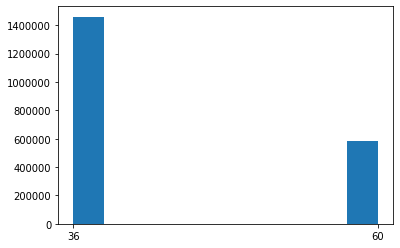

In [0]:
import seaborn as sns
plt.hist(as_data.term)

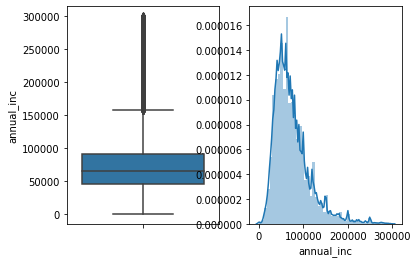

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.annual_inc, orient="v", ax=ax[0])
sns.distplot(as_data.annual_inc, ax=ax[1])

People with income higher than 300,000 will be removed because they are not representative in the sample

In [0]:
as_data = as_data.loc[(as_data.annual_inc < 300000)]

## DTI 


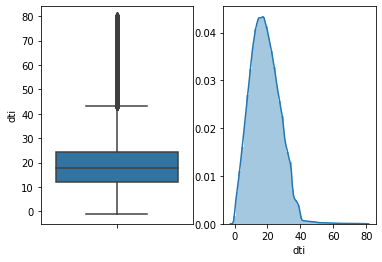

In [0]:

fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.dti, orient="v", ax=ax[0])
sns.distplot(as_data.dti,ax=ax[1])

Dti should be cut off to less than 80

In [0]:
as_data = as_data.loc[(as_data.dti < 80)]

## Delinq 2years

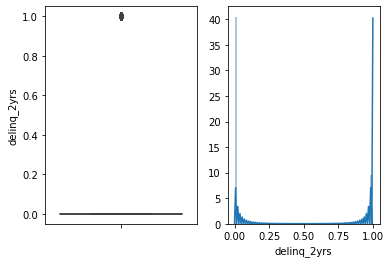

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.delinq_2yrs, orient="v", ax=ax[0])
sns.distplot(as_data.delinq_2yrs,ax=ax[1])

We will remove the outliers delinq 2 years > 30 and make a binary variable 0 and 1 which will mean more than 1 delinq in 2 year

In [0]:
as_data = as_data.loc[(as_data.delinq_2yrs < 21)]

In [0]:
d2y = np.array(as_data[as_data.delinq_2yrs>0].delinq_2yrs.index)
as_data.loc[d2y.transpose(), "delinq_2yrs"] = 1

## Inquiries last 6 months

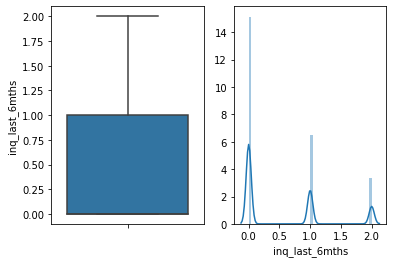

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.inq_last_6mths, orient="v", ax=ax[0])
sns.distplot(as_data.inq_last_6mths,ax=ax[1])

I will re group them from 0, 1 and greater than 2 

In [0]:
il6m = np.array(as_data[as_data.inq_last_6mths>=2].inq_last_6mths.index)
as_data.loc[il6m.transpose(), "inq_last_6mths"] = 2

## Pub Rec

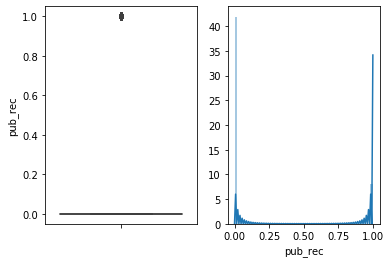

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.pub_rec, orient="v", ax=ax[0])
sns.distplot(as_data.pub_rec,ax=ax[1])

The variable has many outliers we will keep only the ones less than 5 and convert this as a binary variable 0 and 1 one will be the pub records greater than one 0 (1 to 5)

In [0]:
as_data = as_data.loc[(as_data.pub_rec < 6)]

In [0]:
pubrec = np.array(as_data[as_data.pub_rec>=1].inq_last_6mths.index)
as_data.loc[pubrec.transpose(), "pub_rec"] = 1

## Collections 12 months ex med

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.collections_12_mths_ex_med, orient="v", ax=ax[0])
sns.distplot(as_data.collections_12_mths_ex_med,ax=ax[1])

I will be removing this column because even if we convert it to binary the second case wont have 5% of the cases, meaning that this wont be a significant variable  for modelling

In [0]:
as_data.drop(["collections_12_mths_ex_med"], axis=1, inplace=True)

##Mths since last major derog

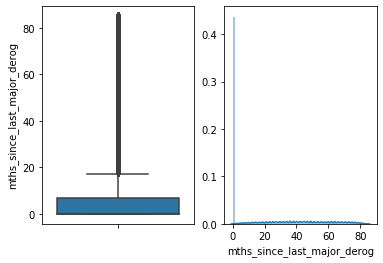

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.mths_since_last_major_derog, orient="v", ax=ax[0])
sns.distplot(as_data.mths_since_last_major_derog,ax=ax[1])

Outliers greater or equal than 86 will be removed

In [0]:
as_data = as_data.loc[(as_data.mths_since_last_major_derog < 86)]

## Acc Now Delinq

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.acc_now_delinq, orient="v", ax=ax[0])
sns.distplot(as_data.acc_now_delinq,ax=ax[1])

We will remove the outliers and make this a binary variable however this does not seem significant, lets wait until the VIF

In [0]:
as_data.drop(["acc_now_delinq"], axis=1, inplace=True)

##Total Collection amount

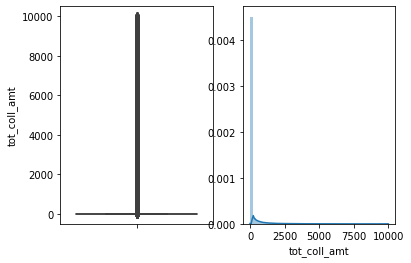

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.tot_coll_amt, orient="v", ax=ax[0])
sns.distplot(as_data.tot_coll_amt,ax=ax[1])

I will remove the outliers greater than 10000




In [0]:
as_data = as_data.loc[(as_data.tot_coll_amt < 10000)]

## Open Account Il

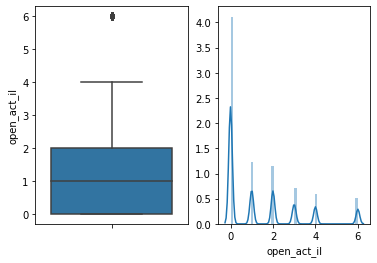

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(as_data.open_act_il, orient="v", ax=ax[0])
sns.distplot(as_data.open_act_il,ax=ax[1])

we will remove the outliers greater than 20 and will regroup  4 to 5 and  6 to 20.

In [0]:
as_data = as_data.loc[(as_data.open_act_il < 20)]

In [0]:
oai = np.array(as_data[as_data.open_act_il>=6].open_act_il.index)
as_data.loc[oai.transpose(), "open_act_il"] = 6

In [0]:
oai45 = np.array(as_data[(as_data.open_act_il>=4) & (as_data.open_act_il<=5)].open_act_il.index)
as_data.loc[oai45.transpose(), "open_act_il"] = 4

## Open il 12 mths

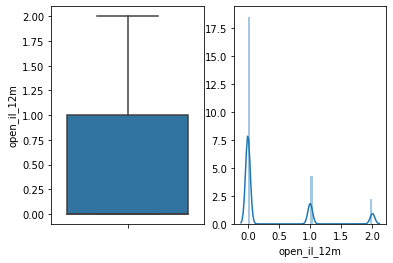

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.open_il_12m, orient="v", ax=ax[0])
sns.distplot(as_data.open_il_12m,ax=ax[1])

We will remove the outliers greater than 5 and regroup to 0 1 and greater than 2 

In [0]:
as_data = as_data.loc[(as_data.open_il_12m <=5)]

In [0]:
oil12 = np.array(as_data[as_data.open_il_12m>=2].open_il_12m.index)
as_data.loc[oil12.transpose(), "open_il_12m"] = 2

## mths since recent il

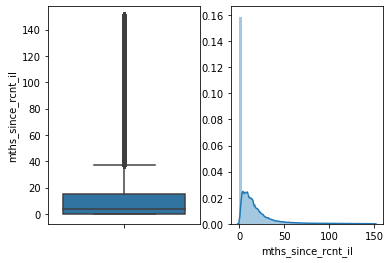

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.mths_since_rcnt_il, orient="v", ax=ax[0])
sns.distplot(as_data.mths_since_rcnt_il,ax=ax[1])

Outliers greater than 150 will be removed

In [0]:
as_data = as_data.loc[(as_data.mths_since_rcnt_il <=150)]

##Il util

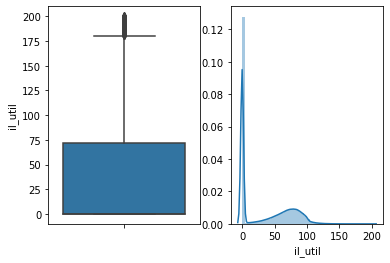

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.il_util, orient="v", ax=ax[0])
sns.distplot(as_data.il_util,ax=ax[1])

Outliers greater than 200 will be removed

In [0]:
as_data = as_data.loc[(as_data.il_util <=200)]

## Max bal bc

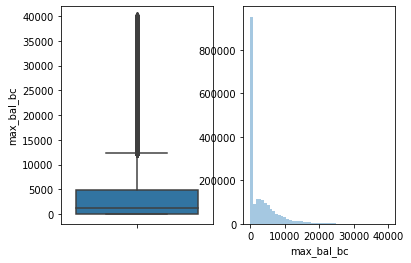

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.max_bal_bc, orient="v", ax=ax[0])
sns.distplot(as_data.max_bal_bc,ax=ax[1], kde=False)

Outliers greater than 40000 will be removed because my model will not be representing them 

In [0]:
as_data = as_data.loc[(as_data.max_bal_bc <=40000)]

## All util

This one is fine



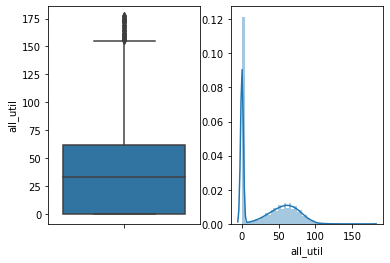

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.all_util, orient="v", ax=ax[0])
sns.distplot(as_data.all_util,ax=ax[1])

## Inq fi

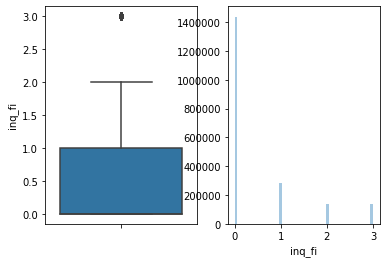

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.inq_fi, orient="v", ax=ax[0])
sns.distplot(as_data.inq_fi,ax=ax[1], kde=False)

Remove outliers greater than 10 and regrouped them 0,1,2 angreater or equal to 3

In [0]:
as_data = as_data.loc[(as_data.inq_fi <=10)]

In [0]:
inqfi = np.array(as_data[as_data.inq_fi>=3].inq_fi.index)
as_data.loc[inqfi.transpose(), "inq_fi"] = 3

##Total Cu Tl

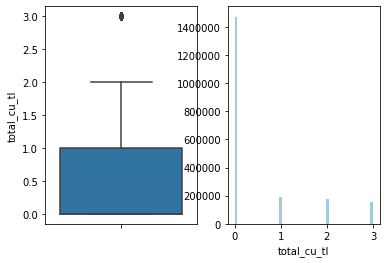

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.total_cu_tl, orient="v", ax=ax[0])
sns.distplot(as_data.total_cu_tl,ax=ax[1], kde=False)

The outliers greater than 20 will be removed and the variables will be regroup 

In [0]:
as_data = as_data.loc[(as_data.total_cu_tl <=20)]

In [0]:
tct23 = np.array(as_data[(as_data.total_cu_tl>=2) & (as_data.total_cu_tl<=3)].total_cu_tl.index)
as_data.loc[tct23.transpose(), "total_cu_tl"] = 2

tct4 = np.array(as_data[(as_data.total_cu_tl>=4)].total_cu_tl.index)
as_data.loc[tct4.transpose(), "total_cu_tl"] = 3

## Inq last 12m

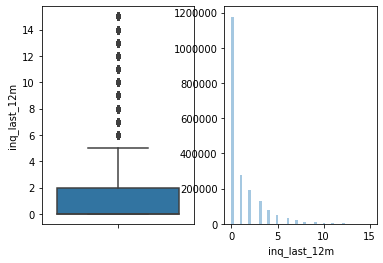

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.inq_last_12m, orient="v", ax=ax[0])
sns.distplot(as_data.inq_last_12m,ax=ax[1], kde=False)

Outliers greater than 15 will be removed

In [0]:
as_data = as_data.loc[(as_data.inq_last_12m <=15)]

## Accounts open past 24 mnths

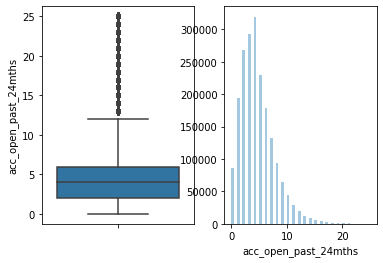

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.acc_open_past_24mths, orient="v", ax=ax[0])
sns.distplot(as_data.acc_open_past_24mths,ax=ax[1], kde=False)

Outilers greater than 25 will be removed



In [0]:
as_data = as_data.loc[(as_data.acc_open_past_24mths <=25)]

#Bc open to buy

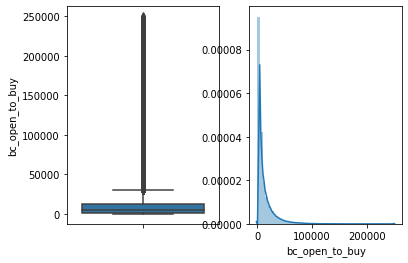

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.bc_open_to_buy, orient="v", ax=ax[0])
sns.distplot(as_data.bc_open_to_buy,ax=ax[1])

Outliers greater than 250000 will be removed

In [0]:
as_data = as_data.loc[(as_data.bc_open_to_buy <=250000)]

## Charged off within 12 mths

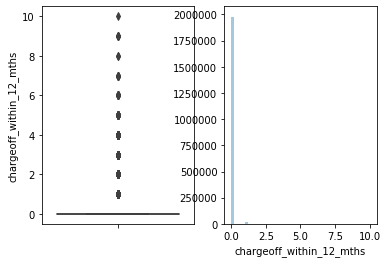

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.chargeoff_within_12_mths, orient="v", ax=ax[0])
sns.distplot(as_data.chargeoff_within_12_mths,ax=ax[1], kde=False)

This variable will be eliminated because even though we converted in binary the second case wont have 5% of the cases, hence it wont be significant

In [0]:
as_data.drop(["chargeoff_within_12_mths"], inplace=True, axis=1)

## Delinq Amount

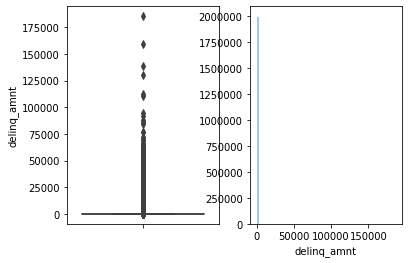

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.delinq_amnt, orient="v", ax=ax[0])
sns.distplot(as_data.delinq_amnt,ax=ax[1], kde=False)

This variable will be eliminated it will be also a insignificant variable

In [0]:
as_data = as_data.loc[(as_data.delinq_amnt <80000)]

In [0]:
as_data.drop(["delinq_amnt"], axis=1, inplace=True)

##Months since old il amount

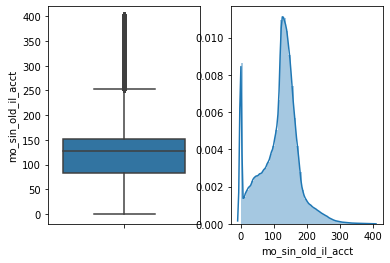

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.mo_sin_old_il_acct, orient="v", ax=ax[0])
sns.distplot(as_data.mo_sin_old_il_acct,ax=ax[1])

Outliers greater than 400 will be removed

In [0]:
as_data = as_data.loc[(as_data.mo_sin_old_il_acct <=400)]

## Months since old revolving

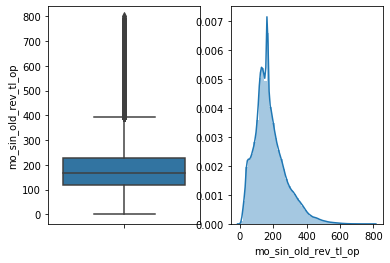

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.mo_sin_old_rev_tl_op, orient="v", ax=ax[0])
sns.distplot(as_data.mo_sin_old_rev_tl_op,ax=ax[1])

outliers greater than 800 will be removed

In [0]:
as_data = as_data.loc[(as_data.mo_sin_old_rev_tl_op <=800)]

## Months since rcnt rev tl op

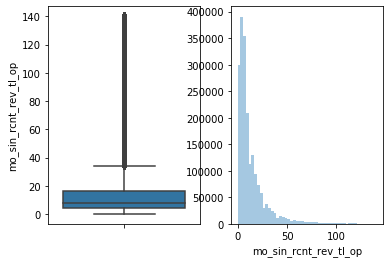

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.mo_sin_rcnt_rev_tl_op, orient="v", ax=ax[0])
sns.distplot(as_data.mo_sin_rcnt_rev_tl_op,ax=ax[1], kde=False)

Outliers greater than 140 will be removed

In [0]:
as_data = as_data.loc[(as_data.mo_sin_rcnt_rev_tl_op <=140)]

## Mths since recent tl

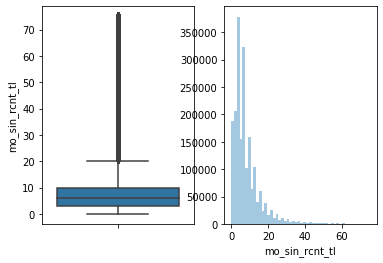

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.mo_sin_rcnt_tl, orient="v", ax=ax[0])
sns.distplot(as_data.mo_sin_rcnt_tl,ax=ax[1], kde=False)

outliers greater than 75 will be removed

In [0]:
as_data = as_data.loc[(as_data.mo_sin_rcnt_tl <=75)]

## Mort acc

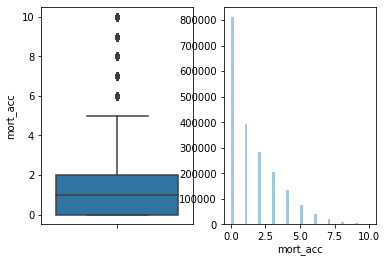

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.mort_acc, orient="v", ax=ax[0])
sns.distplot(as_data.mort_acc,ax=ax[1], kde=False)

Outliers greater than 10 accounts will be removed

In [0]:
as_data = as_data.loc[(as_data.mort_acc <=10)]

## Months since recent bc

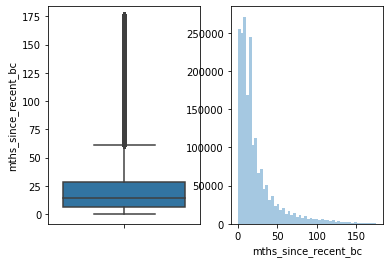

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.mths_since_recent_bc, orient="v", ax=ax[0])
sns.distplot(as_data.mths_since_recent_bc,ax=ax[1], kde=False)

Outliers greater than 175 will be removed

In [0]:
as_data = as_data.loc[(as_data.mths_since_recent_bc <=175)]

## Num of accounts ever 120

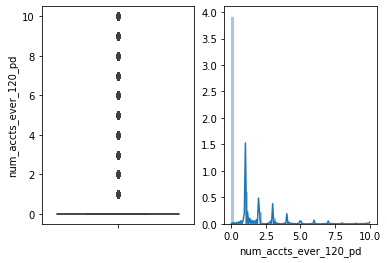

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.num_accts_ever_120_pd, orient="v", ax=ax[0])
sns.distplot(as_data.num_accts_ever_120_pd,ax=ax[1], kde=True)

Outliers greater than 10 will be removed

In [0]:
as_data = as_data.loc[(as_data.num_accts_ever_120_pd <=10)]

## Num actv rev tl 


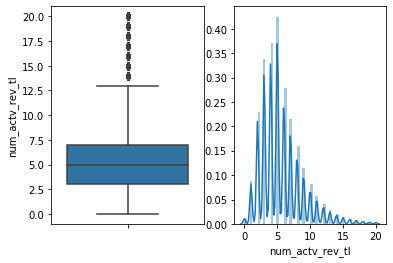

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.num_actv_rev_tl, orient="v", ax=ax[0])
sns.distplot(as_data.num_actv_rev_tl,ax=ax[1], kde=True)

The outliers above 20 will be removed

In [0]:
as_data = as_data.loc[(as_data.num_actv_rev_tl <=20)]

## Num il tl

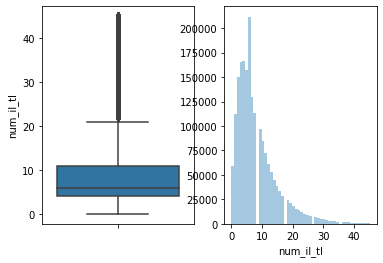

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.num_il_tl, orient="v", ax=ax[0])
sns.distplot(as_data.num_il_tl,ax=ax[1], kde=False)

The outliers above 45 will be removed

In [0]:
as_data = as_data.loc[(as_data.num_il_tl <=45)]

## num rev accnt

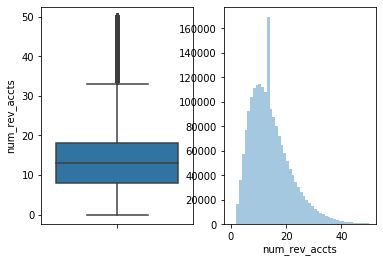

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.num_rev_accts, orient="v", ax=ax[0])
sns.distplot(as_data.num_rev_accts,ax=ax[1], kde=False)

Outliers above 50 will be removed

In [0]:
as_data = as_data.loc[(as_data.num_rev_accts <=50)]

## Num tl 120dpd 2m

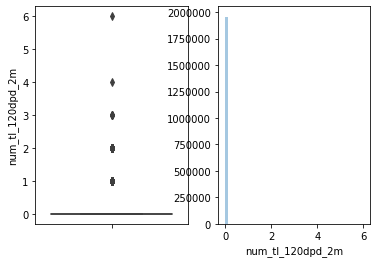

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.num_tl_120dpd_2m, orient="v", ax=ax[0])
sns.distplot(as_data.num_tl_120dpd_2m,ax=ax[1], kde=False)

this variable will not be significant to the model even if we make it binary, so we will remove it 

In [0]:
as_data.drop(["num_tl_120dpd_2m"],inplace=True,  axis=1)

## Num tl 90g dpd 24m

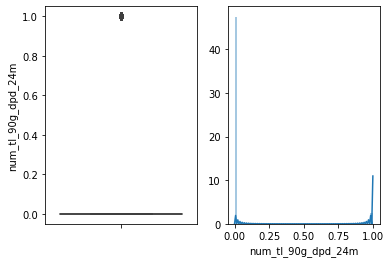

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.num_tl_90g_dpd_24m, orient="v", ax=ax[0])
sns.distplot(as_data.num_tl_90g_dpd_24m, ax=ax[1], kde=True)

We will remove the outliers greater than 8 and convert this variable to binary. 

In [0]:
as_data = as_data.loc[(as_data.num_tl_90g_dpd_24m <8)]

In [0]:
ntd90 = np.array(as_data[(as_data.num_tl_90g_dpd_24m>0)].num_tl_90g_dpd_24m.index)
as_data.loc[ntd90.transpose(), "num_tl_90g_dpd_24m"] = 1

## Percent of trades never delinquent

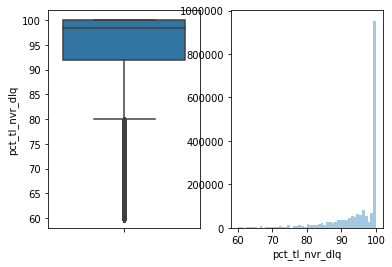

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.pct_tl_nvr_dlq, orient="v", ax=ax[0])
sns.distplot(as_data.pct_tl_nvr_dlq, ax=ax[1], kde=False)

outliers less than 60 will be removed

In [0]:
as_data = as_data.loc[(as_data.pct_tl_nvr_dlq >=60)]

##Percent bc gt 75
this one is fine

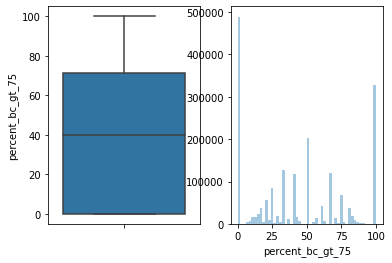

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.percent_bc_gt_75, orient="v", ax=ax[0])
sns.distplot(as_data.percent_bc_gt_75, ax=ax[1], kde=False)

## Pub rec bankuptcies

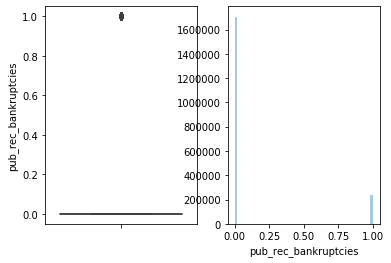

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.pub_rec_bankruptcies, orient="v", ax=ax[0])
sns.distplot(as_data.pub_rec_bankruptcies, ax=ax[1], kde=False)

This variable will be transdorm into a binary variable

In [0]:
pubrecbank = np.array(as_data[(as_data.pub_rec_bankruptcies>0)].pub_rec_bankruptcies.index)
as_data.loc[pubrecbank.transpose(), "pub_rec_bankruptcies"] = 1

## Tot hi cred limit

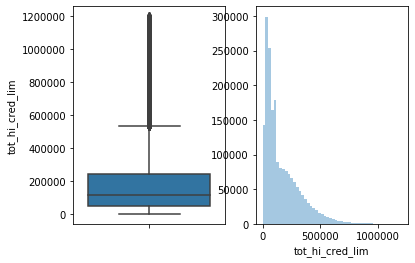

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.tot_hi_cred_lim, orient="v", ax=ax[0])
sns.distplot(as_data.tot_hi_cred_lim, ax=ax[1], kde=False)

outliers greater than 1.2 million will be removed

In [0]:
as_data = as_data.loc[(as_data.tot_hi_cred_lim <=1200000)]

## Tot il hi cred limit

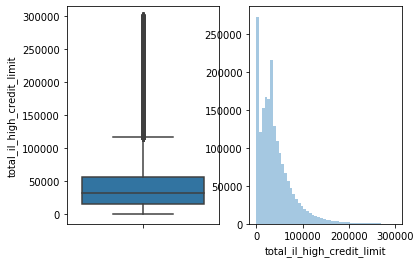

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(as_data.total_il_high_credit_limit, orient="v", ax=ax[0])
sns.distplot(as_data.total_il_high_credit_limit, ax=ax[1], kde=False)

outliers greater than 300000 will be removed

In [0]:
as_data = as_data.loc[(as_data.total_il_high_credit_limit <=300000)]

Last Step of Data Preprocessing, I will group the states into regions, so they will be significant.

In [0]:
reg_dic = {"CT":"1", "ME":"1", "MA":"1", "NH":"1", "RI":"1", "VT":"1",
           "NY":"2", "NJ":"2", "PA":"2",
           "WI":"3", "MI":"3", "IL":"3", "IN":"3", "OH":"3",
           "ND":"4", "MN":"4", "SD":"4", "NE":"4", "IA":"4", "KS":"4", "MO":"4",
           "MD":"5", "DE":"5", "WV":"5", "DC":"5", "VA":"5", "NC":"5", "SC":"5", "GA":"5", "FL":"5",
           "KY":"6", "TN":"6", "AL":"6", "MS":"6", 
           "AR":"7", "OK":"7", "LA":"7", "TX":"7",
           "MT":"8", "ID":"8", "WY":"8", "NV":"8", "UT":"8", "CO":"8", "AZ":"8", "NM":"8",
           "WA":"9", "OR":"9", "CA":"9", "AK":"9", "HI":"9"
           }

In [0]:
as_data["addr_region"] = as_data.addr_state.map(reg_dic) 


In [0]:
as_data.drop(["addr_state"], axis=1, inplace=True)

Making homeownership significant

In [0]:
# We will add any other and none to the rent category
rent = np.array(as_data[(as_data.home_ownership == "ANY") | (as_data.home_ownership == "OTHER") | (as_data.home_ownership == "NONE")].home_ownership.index)
as_data.loc[rent.transpose(), "home_ownership"] = "RENT"

In [0]:
as_data.home_ownership.value_counts()

MORTGAGE    947616
RENT        773874
OWN         215269
Name: home_ownership, dtype: int64

Making the purpose columns significant

Medical, car, vacation, moving, house, wedding, education will be put in a category call living_leasure_expenses 

major_purchase, small_business and renewable_energy will be include in others

In [0]:
purpose1 = np.array(as_data[(as_data.purpose == "medical") | (as_data.purpose == "car") | (as_data.purpose == "vacation") |
                        (as_data.purpose == "moving") | (as_data.purpose == "house") | (as_data.purpose == "wedding") |
                        (as_data.purpose == "educational")].purpose.index)
as_data.loc[purpose1.transpose(), "purpose"] = "liv_leisure_exp" 

In [0]:
purpose2 = np.array(as_data[(as_data.purpose == "small_business") | (as_data.purpose == "renewable_energy") | (as_data.purpose == "major_purchase")].purpose.index)
as_data.loc[purpose2.transpose(), "purpose"] = "other"

Checking the columns

In [0]:
len(as_data.columns)

45

In [0]:
len(as_data)

1936759

Saving the variables

In [0]:
from google.colab import files


In [0]:
as_data.to_csv("as_data.csv", index=False)